In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
import os
from string import punctuation
from typing import Tuple, Union, List

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dataset = pd.read_excel("/content/Haber_Etiketli.xlsx")

In [ ]:
dataset.shape

(14369, 4)

#CountValues of Categories

In [ ]:
dataset['Label'].value_counts()

,count
Label,
negatif,4701
pozitif,3861
nötr,3510
karışık,2264
belirsiz,31
hata,2


In [ ]:
dataset1 = dataset[~dataset['Label'].isin(['belirsiz', 'hata'])]

In [ ]:
dataset1['Label'].value_counts()

,count
Label,
negatif,4701
pozitif,3861
nötr,3510
karışık,2264


##Convert Categories Name into Numerical Index

In [ ]:
target_Label = dataset1['Label'].unique()
print(target_Label)

['negatif' 'pozitif' 'karışık' 'nötr']


In [ ]:
label_mapping = {
    'pozitif': 0,
    'negatif': 1,
    'nötr': 2,
    'karışık': 3
}

In [ ]:
dataset1['label_id'] = dataset1['Label'].map(label_mapping)

<ipython-input-9-6642ddbf6a3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['label_id'] = dataset1['Label'].map(label_mapping)


In [ ]:
dataset1.tail()

,Label,Dosya Adı,Başlık,İçerik,label_id
14364,nötr,995.txt,Diyanet 400 bin hadis taradı 20 bin hadisi 6 c...,Türkiyenin önde gelen 100 hadis uzmanının kat...,2
14365,karışık,996.txt,Haczedilen yalı için CHP destek vermedi,Türk siyasetinde önemli yeri olan İnönü Ailesi...,3
14366,nötr,997.txt,Terör propagandasına ayrıntılı tanım geliyor,Terör örgütü üyesi olmayıp da terör örgütü pro...,2
14367,karışık,998.txt,28 Şubat kararları iptal edilsin,"Umut davası kapsamında yargılanan 3 sanık, üye...",3
14368,negatif,999.txt,Ünal Erkana işkence sorgusu,12 Eylül işkence soruşturması kapsamında dönem...,1


##Show Category’s Name w.r.t Category ID

In [ ]:
Label = dataset1[['Label', 'label_id']].drop_duplicates().sort_values('label_id')
print(Label)

     Label  label_id
1  pozitif         0
0  negatif         1
6     nötr         2
5  karışık         3


##Exploratory Data Analysis (EDA)

#Visualizing Data

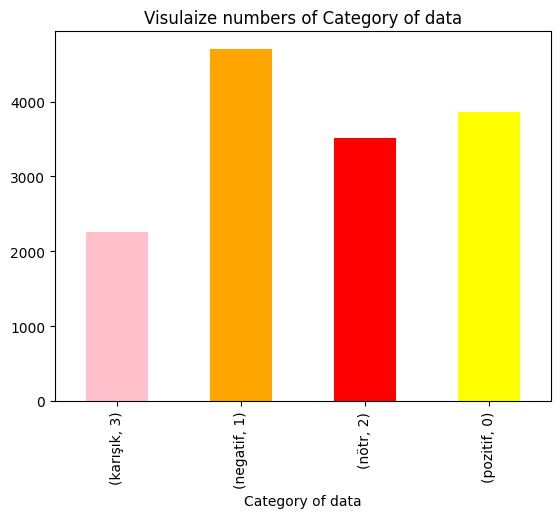

In [ ]:
dataset1.groupby('Label').label_id.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

#Visualizing Category Related Words

In [ ]:
haber_içeriği = dataset1["İçerik"]
haber_içeriği.head(10)

,İçerik
0,"Golf Federasyonu Başkanı Ağaoğlu, gazeteci ile..."
1,"Çevre ve Şehircilik Bakanlığı, fabrika bacalar..."
2,"Bakanlık yetkililerinden alınan bilgiye göre, ..."
3,Ağrıda çekilen fotoğraflarda yer alan cisimle...
4,Göktürk-2 uydusununun fırlatılması sırasında y...
5,BATMAN Çayında geçen hafta boğularak öldürülm...
6,"Yargıtay Ceza Genel Kurulu, mahkeme kararına d..."
7,"CHP Genel Başkanı Kemal Kılıçdaroğlu, gazeteci..."
8,"MHP Grup Başkanvekili Oktay Vural, Başbakan Ta..."
9,"Başbakan Yardımcısı Bülent Arınç, Genelkurmay..."


In [ ]:
def remove_tags(text):
    # Example regex to remove URLs
    remove = re.compile(r'http[s]?://\S+')
    return re.sub(remove, '', text)

In [ ]:
def convert_lower(text):
    # Check if the text is a string, then convert to lowercase
    if isinstance(text, str):
        return text.lower()
    # Return the text as-is if it's not a string
    return text

# Ensure all entries are treated as strings before applying the function
dataset1['İçerik'] = dataset1['İçerik'].astype(str).apply(convert_lower)

# Verify the result
print(dataset1['İçerik'][1])

çevre ve şehircilik bakanlığı, fabrika bacalarından çıkan kirletici gazları 12 ekim'den itibaren online izlemeye başlayacak. sınır değerin üzerinde kirleten tesislere yaptırım uygulanacak.
 çevre ve şehircilik bakanlığı'nın, daha sağlıklı veriler alınabilmesi amacıyla sürekli emisyon ölçüm sistemlerinin seçimi, kurulumu, kalibrasyonu, bakımı ve işletiminde dikkat edilecek konuları düzenlediği ''sürekli emisyon ölçüm sistemleri tebliği'', 12 ekim'de yürürlüğe giriyor.
 tebliğin yürürlüğe girmesiyle, kirletici vasfı yüksek sanayi tesislerinin bacalarındaki ölçüm cihazlarından elde edilen veriler, anında bakanlığın gölbaşı hizmet binasında kurulan online izleme merkezine aktarılacak.
 sistemle, yönetmeliklerdeki sınır değerlerin üzerinde kirletici yaydığı tespit edilen sanayi tesislerine yaptırım uygulanacak.
 aa


<ipython-input-15-398efa364d2f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['İçerik'] = dataset1['İçerik'].astype(str).apply(convert_lower)


In [ ]:
dataset1

,Label,Dosya Adı,Başlık,İçerik,label_id
0,negatif,1.txt,'Basından özür dilerim',"golf federasyonu başkanı ağaoğlu, gazeteci ile...",1
1,pozitif,10.txt,Kirletici gazlara online takip,"çevre ve şehircilik bakanlığı, fabrika bacalar...",0
2,pozitif,100.txt,Öğretmen maaşlarına zam!,"bakanlık yetkililerinden alınan bilgiye göre, ...",0
3,pozitif,1000.txt,Fotoğraflardaki görüntüler UFO mu?,ağrıda çekilen fotoğraflarda yer alan cisimle...,0
4,negatif,1001.txt,Gerçekler yansıtıldığı gibi değil,göktürk-2 uydusununun fırlatılması sırasında y...,1
...,...,...,...,...,...
14364,nötr,995.txt,Diyanet 400 bin hadis taradı 20 bin hadisi 6 c...,türkiyenin önde gelen 100 hadis uzmanının kat...,2
14365,karışık,996.txt,Haczedilen yalı için CHP destek vermedi,türk siyasetinde önemli yeri olan i̇nönü ailes...,3
14366,nötr,997.txt,Terör propagandasına ayrıntılı tanım geliyor,terör örgütü üyesi olmayıp da terör örgütü pro...,2
14367,karışık,998.txt,28 Şubat kararları iptal edilsin,"umut davası kapsamında yargılanan 3 sanık, üye...",3


##Tokanizasyon

In [ ]:
from typing import List, Tuple, Union
# Özel kelime tokenizasyon fonksiyonu
def word_tokenize(sentence: str, word_regex: re.Pattern) -> Tuple:
    try:
        words: Union[List] = word_regex.findall(sentence)
    except (re.error, TypeError):
        return ()
    else:
        words: Union[Tuple] = tuple(words)
        if words:
            end_dots = re.search(r'\b(\.+)$', words[-1])
            if end_dots:
                dots: str = end_dots.group(1)
                words = words[:-1] + (words[-1][:-len(dots)],) + (dots,)
        return words

# Basit kelime tokenizasyon deseni için regex deseni oluştur
word_regex = re.compile(r'\b\w+\b')

In [ ]:
# "İçerik" sütununun var olup olmadığını kontrol et
if "İçerik" in dataset1.columns:
    # "İçerik" sütunundaki her hücreyi özel word_tokenize fonksiyonunu kullanarak tokenle
    dataset1['Tokenized_İçerik'] = dataset1['İçerik'].apply(lambda x: word_tokenize(str(x), word_regex) if pd.notna(x) else '')
    print("Tokenizasyon tamamlandı.")
else:
    print("excel dosyasında 'İçerik' sütunu bulunamadı.")

Tokenizasyon tamamlandı.


<ipython-input-18-4f357aae0495>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['Tokenized_İçerik'] = dataset1['İçerik'].apply(lambda x: word_tokenize(str(x), word_regex) if pd.notna(x) else '')


In [ ]:
# Noktalama işaretlerini kaldırma fonksiyonu
def remove_punctuations(cell):
    if isinstance(cell, str):
        return re.sub(r'[.,!?;:\'"]', '', cell)
    return cell

In [ ]:
# Noktalama işaretlerini kaldırma fonksiyonunu DataFrame'in her hücresine uygula
dataset_temiz = dataset1.applymap(remove_punctuations)

<ipython-input-20-80dc00dd404a>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_temiz = dataset1.applymap(remove_punctuations)


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 19.1 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode
# Metin işleme fonksiyonu
def process_text(text):
    # 1. Metni küçük harfe dönüştür
    text = text.lower()
    # 2. Aksanlı karakterleri standartlaştır
    text = unidecode(text)
    # 4. Bahsetmelerin ve hashtaglerin kaldırılması
    text = re.sub(r'@\w+', '', text)  # Bahsetmeleri kaldır
    text = re.sub(r'#\w+', '', text)  # Hashtagleri kaldır
    # 5. Özel karakterlerin kaldırılması
    text = re.sub(r'[^\w\s]', '', text)  # Özel karakterleri kaldır
    return text

In [ ]:
# Define Turkish stop words manually
turkish_stop_words = set([
    'a', 'ama', 'ancak', 'araba', 'bana', 'bazen', 'belki', 'bir', 'bu', 'bunu', 'her', 'hiç',
    'için', 'ile', 'önce', 've', 'veya', 'çok', 'da', 'de', 'diğer', 'daha', 'ne', 'niçin',
    'sadece', 'şu', 'şuna', 'şunu', 'şöyle', 'herhangi', 'nasıl', 'şey', 'veya'
])

# Stop words kaldıran fonksiyon
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in turkish_stop_words]
    return ' '.join(filtered_words)

Tokenized_İçerik = remove_stop_words('Tokenized_İçerik')

In [ ]:
# Örnek Türkçe bağlaçlar listesi (gerçek bir liste kullanmalısınız)
turkish_conjunctions = set([
    've', 'veya', 'ama', 'da', 'de', 'ile', 'mi', 'mı', 'mu', 'mü', 'ki', 'gibi', 'nin'
    # Gerçek listeyi TÜBİTAK NLP'den veya diğer kaynaklardan temin edin
])

# Bağlaçları kaldıran fonksiyonu güncelle
def remove_conjunctions_from_tokens(tokens):
    filtered_tokens = [token for token in tokens if token not in turkish_conjunctions]
    return filtered_tokens

dataset_temiz['Tokenized_İçerik'] = dataset_temiz['Tokenized_İçerik'].apply(remove_conjunctions_from_tokens)

##Model

In [ ]:
from sklearn.model_selection import train_test_split
# Eğitim ve test setlerine böl
train_data, test_data = train_test_split(dataset_temiz, test_size=0.2, random_state=42)

In [ ]:
print("Eğitim seti boyutu:", len(train_data))
print("Test seti boyutu:", len(test_data))

Eğitim seti boyutu: 11468
Test seti boyutu: 2868


In [ ]:
# BERT tokenizasyonu için tokenizer'ı yükle
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 3e-5

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

In [ ]:
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('val_accuracy')
datamin_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/model1.h5'),
]

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Tokenizer ve model yükle
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-cased')
model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-128k-cased', num_labels=4)  # 4 etiketli sınıflandırma

# Veriyi oku
df = dataset_temiz

# Eğitim ve test setlerine ayır
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizasyon fonksiyonu
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

# TensorFlow veri kümesi oluşturma
def create_tf_dataset(df):
    encodings = tokenize_function(df['İçerik'].tolist())
    labels = df['label_id'].tolist()
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    dataset = dataset.shuffle(len(df)).batch(8)  # Batch size
    return dataset

train_dataset = create_tf_dataset(train_df)
val_dataset = create_tf_dataset(val_df)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Model ve optimizer tanımlama
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Modeli derleme
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Modeli eğitme
bert_history = model.fit(
    train_dataset,
    batch_size=16,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
    ]
)

Epoch 1/30
1434/1434 [==============================] - 184s 99ms/step - loss: 1.2265 - accuracy: 0.4360 - val_loss: 1.0665 - val_accuracy: 0.5453 - lr: 1.0000e-05
Epoch 2/30
1434/1434 [==============================] - 128s 89ms/step - loss: 0.9897 - accuracy: 0.5845 - val_loss: 0.9238 - val_accuracy: 0.6419 - lr: 1.0000e-05
Epoch 3/30
1434/1434 [==============================] - 127s 89ms/step - loss: 0.8648 - accuracy: 0.6507 - val_loss: 0.9279 - val_accuracy: 0.6294 - lr: 1.0000e-05
Epoch 4/30
1434/1434 [==============================] - 126s 88ms/step - loss: 0.7413 - accuracy: 0.7056 - val_loss: 0.9013 - val_accuracy: 0.6419 - lr: 1.0000e-05
Epoch 5/30
1434/1434 [==============================] - 127s 89ms/step - loss: 0.6328 - accuracy: 0.7558 - val_loss: 0.9982 - val_accuracy: 0.6419 - lr: 1.0000e-05
Epoch 6/30
1434/1434 [==============================] - 127s 89ms/step - loss: 0.5186 - accuracy: 0.8075 - val_loss: 1.1206 - val_accuracy: 0.6276 - lr: 1.0000e-05
Epoch 7/30
1434/

In [ ]:
model.save_weights('model_weights3.h5')

In [142]:
'''bert_history = model.fit(
    train_dataset,
    batch_size=256,
    epochs=5,  # İhtiyaca göre epoch sayısını ayarlayabilirsiniz
    validation_data=val_dataset,
    callbacks=datamin_callbacks  # Opsiyonel: Eğitim sırasında geri çağırmaları kullanabilirsiniz
)'''

'bert_history = model.fit(\n    train_dataset,\n    batch_size=256,\n    epochs=5,  # İhtiyaca göre epoch sayısını ayarlayabilirsiniz\n    validation_data=val_dataset,\n    callbacks=datamin_callbacks  # Opsiyonel: Eğitim sırasında geri çağırmaları kullanabilirsiniz\n)'

In [ ]:
model.save_weights('model_weights4.h5')

In [ ]:
'''model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-128k-cased', num_labels=4)

# Load the model weights
model.load_weights('model_weights.h5')'''

"model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-128k-cased', num_labels=4)\n\n# Load the model weights\nmodel.load_weights('model_weights.h5')"

In [ ]:
'''from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')'''


In [ ]:
'''from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased')'''



In [ ]:
'''tokenizer = BertTokenizer.from_pretrained('dbmdz/distilbert-base-turkish-cased', do_lower_case=True)'''


In [136]:
text = '''Geçtiğimiz günlerde Teknoparktaki enerji şirketi çalışanlarına çok iyi davranmalarıyla gündeme gelmişti. Çalışanlarından Burcu K. çalışanlarına iyi davrandıklarını ancak çok da abartılacak bir durum olmadığını açıkladı.'''

In [137]:
inputs = tokenizer((text),
                   add_special_tokens=True,  # add [CLS], [SEP]
                   max_length=512,  # max length of the text that can go to BERT
                   pad_to_max_length=True,  # add [PAD] tokens
                   return_attention_mask=True,  # add attention mask to not focus on pad tokens
                   return_tensors="tf",
                   truncation=True
                   )

In [138]:
outputs = model(inputs, return_dict=True, labels=1)

In [139]:
logits = outputs.logits
pred = tf.nn.softmax(logits)

In [140]:
# Define your label dictionary
label_dict = {
    0: 'pozitif',
    1: 'negatif',
    2: 'nötr',
    3: 'karışık'
}

In [141]:
max_idx = np.argmax(pred[0], 0)

print(label_dict[max_idx], pred[0][max_idx])
# spor tf.Tensor(0.9996449, shape=(), dtype=float32)

nötr tf.Tensor(0.8507591, shape=(), dtype=float32)


In [ ]:
print(test_data.dtypes)

Label               object
Dosya Adı           object
Başlık              object
İçerik              object
label_id             int64
Tokenized_İçerik    object
dtype: object


In [ ]:
test_data

,Label,Dosya Adı,Başlık,İçerik,label_id,Tokenized_İçerik
6368,pozitif,1468txt,Dünyanın yeni sağlık bilim merkezi olacak,bahçeşehir üniversitesi türk tıbbını dünyanın ...,0,"[bahçeşehir, üniversitesi, türk, tıbbını, düny..."
3064,nötr,3757txt,Sayısal Loto çekiliş sonuçları (16022013),sayısal lotonun bu haftaki çekilişi yapıldı\nm...,2,"[sayısal, loto, nun, bu, haftaki, çekilişi, ya..."
9524,negatif,4308txt,Ümraniyede TIR kazası 1 ölü,ümrani̇ye tem otoyolunda güvenlik şeridinde p...,1,"[ümrani, ye, tem, otoyolu, nda, güvenlik, şeri..."
170,nötr,1151txt,Nüfus Cüzdanını kaybetti başına gelmeyen kalmadı,samsunda 4 yıl önce nüfus cüzdanını kaybeden f...,2,"[samsun, 4, yıl, önce, nüfus, cüzdanını, kaybe..."
11230,nötr,5844txt,Sessiz ve derinden son 16ya,fbahçe kadıköydeki seyircisiz maçta bateyi k...,2,"[f, bahçe, kadıköy, deki, seyircisiz, maçta, b..."
...,...,...,...,...,...,...
9595,nötr,4372txt,İnkâr Yasası yerine Erivan,fransa cumhurbaşkanı hollande ermeni diyaspora...,2,"[fransa, cumhurbaşkanı, hollande, ermeni, diya..."
5615,karışık,790txt,Mütalaa yok biber gazı var,eski genelkurmay başkanı emekli orgeneral i̇lk...,3,"[eski, genelkurmay, başkanı, emekli, orgeneral..."
4403,pozitif,4962txt,Miriam Makeba kimdir,google afrikalı şarkıcı ve sivil halklar eylem...,0,"[google, afrikalı, şarkıcı, sivil, halklar, ey..."
5726,nötr,890txt,İtibarları kaybolmadı ki geri isteyelim,tbmmnin asılarak idam edilen eski başbakan ad...,2,"[tbmm, asılarak, idam, edilen, eski, başbakan,..."


In [ ]:
# Assuming test_data is still a pandas DataFrame
X_test = test_data.iloc[:, 3]  # Only the 'içerik' column (4th column)
y_test = test_data.iloc[:, 4]  # The labels column (5th column)

In [143]:
'''X_test = X_test.values
y_test = y_test.values'''

'X_test = X_test.values\ny_test = y_test.values'

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the 'içerik' column
X_test_tokenized = tokenizer(
    list(X_test),  # Convert to list if it's a pandas Series
    padding=True,
    truncation=True,
    return_tensors='tf'
)

In [ ]:
# Convert labels to tensors
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [ ]:
# Assuming 'X_test_tokenized' has been created as shown before
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(
        input_ids=X_test_tokenized['input_ids'],
        attention_mask=X_test_tokenized['attention_mask'],
        token_type_ids=X_test_tokenized.get('token_type_ids')  # Optional, depends on tokenizer
    ),
    y_test_tensor
)).batch(16)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

180/180 [==============================] - 59s 306ms/step - loss: 3.4209 - accuracy: 0.2186
Test Loss: 3.4209
Test Accuracy: 0.2186


In [ ]:
# Get the raw predictions (logits)
predictions = model.predict(test_dataset)

In [ ]:
# Convert logits to class labels (assuming the last dimension contains the logits for each class)
predicted_classes = tf.argmax(predictions.logits, axis=-1).numpy()

In [ ]:
# Display or use the predicted classes
print(predicted_classes)

In [ ]:
from tensorflow.keras.optimizers import Adam

def model_builder(hp):
    # Hyperparameter ranges
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 3e-5, 5e-5])

    # Model definition
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Compile the model with the learning rate as a hyperparameter
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss=model.compute_loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
model.compile(
    optimizer='adam',  # or 'Adam' as a string identifier
    loss=model.compute_loss,
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Define your model
model = tf.keras.models.Sequential([
    # Add your layers here
])

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Example learning rate
    loss=model.compute_loss,
    metrics=['accuracy']
)


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = tf.keras.models.Sequential([
        # Add your layers here
    ])

    # Define optimizer using Keras Tuner's hyperparameters
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss=model.compute_loss,
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1
)

tuner.search(train_data, epochs=3,  validation_data=validation_data)
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(model_builder, objective='val_accuracy', max_trials=10, executions_per_trial=1)
tuner.search(train_dataset, epochs=3, validation_data=val_dataset)
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.fit(train_dataset, epochs=3)
test_loss, test_accuracy = best_model.evaluate(val_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-cased')
model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-128k-cased', num_labels=4)
model.load_weights('model_weights3.h5')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
val_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Model tahminleri al
predictions = model.predict(val_dataset)
logits = predictions.logits
predicted_labels = np.argmax(logits, axis=-1)


359/359 [==============================] - 13s 27ms/step


In [ ]:
true_labels = []
for _, labels in val_dataset:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)


In [ ]:
# Confusion matrix ve classification report hesapla
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)



Confusion Matrix:
 [[191 254 178 156]
 [253 263 227 199]
 [198 205 174 134]
 [130 112 114  80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.25      0.25       779
           1       0.32      0.28      0.30       942
           2       0.25      0.24      0.25       711
           3       0.14      0.18      0.16       436

    accuracy                           0.25      2868
   macro avg       0.24      0.24      0.24      2868
weighted avg       0.25      0.25      0.25      2868

